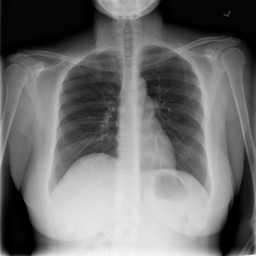

In [18]:
import os
from PIL import Image


lung_path = "data\\train_images"
mask_path = "data\\train_lung_masks"
result_path = "data\\lung_overlay"

for filename in os.listdir(lung_path):
    mask = Image.open(f'{mask_path}\\{filename}')
    lung = Image.open(f'{lung_path}\\{filename}')
    if mask.size == lung.size:
        mask_pixels = mask.load()
        lung_pixels = lung.load()
        width, height = mask.size
        for x in range(width):
            for y in range(height):
                if mask_pixels[x, y] == (0, 0, 0):
                    lung_pixels[x, y] = (0, 0, 0)

        save_path = os.path.join(result_path, filename)
        lung.save(save_path)

    display(lung)
    break